In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import random
#import pysal as ps
from scipy.stats import stats
from functools import reduce

## 1. Load and process ACS and county shapefile data

In [146]:
# ID columns for study
cols = {'DP02_0002PE' : 'married',
        'DP02_0004PE' : 'cohab',
        'DP02_0005PE' : 'cohab_children',
        'DP02_0016E'  : 'avg_hhsz',
        'DP02_0021PE' : 'pct_unmarpartner',
        'DP02_0024PE' : 'pct_nonrelative',
        'DP02_0068PE' : 'pct_educ',
        'DP02_0093PE' : 'pct_fb',
        'DP03_0009PE' : 'unempl',
        'DP03_0025E'  : 'avg_com',
        'DP03_0033PE' : 'pct_ag',
        'DP03_0035PE' : 'pct_manu',
        'DP03_0062E'  : 'med_inc',
        'DP03_0088E'  : 'inc_pc',
        'DP03_0128PE' : 'pct_pov',
        'DP04_0047PE' : 'pct_rent',
        'DP04_0058PE' : 'pct_no_veh',
        'DP04_0089E'  : 'med_homeval',
        'DP04_0134E'  : 'med_rent',
        'DP05_0001E'  : 'pop',
        'DP05_0004E'  : 'sex_ratio',
        'DP05_0009PE' : 'pct_20_24',
        'DP05_0010PE' : 'pct_25_34',
        'DP05_0019PE' : 'pct_un18',
        'DP05_0024PE' : 'pct_ov65',
        'DP05_0038PE' : 'pct_black',
        'DP05_0044PE' : 'pct_asian',
        'DP05_0071PE' : 'pct_hisp',
        'B19083_001E' : 'gini'}

In [147]:
# suppress mixed data type warnings
import warnings
warnings.filterwarnings("ignore")

# load acs data
path = 'data/acs2019/acs2019_'
#skip = [1]
dp02 = pd.read_csv(path + 'DP02.csv',)# skiprows=skip)
dp03 = pd.read_csv(path + 'DP03.csv',)# skiprows=skip)
dp04 = pd.read_csv(path + 'DP04.csv',) #skiprows=skip)
dp05 = pd.read_csv(path + 'DP05.csv',)# skiprows=skip)
gini = pd.read_csv(path + 'gini.csv',)# skiprows=skip)

In [148]:
# merge all acs tables
acs_lst = [dp02, dp03, dp04, dp05, gini]
acs = reduce(lambda left, right: pd.merge(left, right, on=['GEO_ID', 'NAME'], how='inner'), acs_lst)

# rename acs cols using dict
acs = acs.rename(columns=cols)

In [149]:
# drop unneeded cols, remove weird first row, trim GEOID for shp merge, and remove duped cols
acs = acs[acs.columns.drop(list(acs.filter(regex='_0')))]
acs = acs[1:]
acs['GEO_ID'] = acs['GEO_ID'].str.replace('0500000US', '')

<AxesSubplot:>

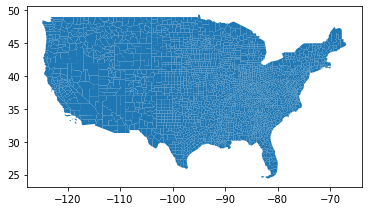

In [150]:
# create GDF thru merge w shp
ct = gpd.read_file('../668 final project/source_files/contig_us_county')
gdf_us = ct.merge(acs, how='inner', left_on='GEOID', right_on='GEO_ID', suffixes=('_SH',''))

# drop unneeded cols
geo_cols = ['GEO_ID', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'METDIVFP',
            'FUNCSTAT', 'INTPTLAT', 'INTPTLON', 'CBSAFP']

gdf_us = gdf_us.drop(columns=geo_cols)
gdf_us.plot()

In [151]:
# create list of variable names, remove strings, convert vars to float
var = list(cols.values())
gdf_us[var] = gdf_us[var].replace(['N', '-'], np.nan)
gdf_us[var] = gdf_us[var].astype('float')

# verify (false is good)
(gdf_us[var].dtypes == 'O').any()

False

In [152]:
# create state column and drop leftover col
gdf_us[['NAME', 'STATE']] = gdf_us['NAME'].str.split(', ', expand=True)
gdf_us = gdf_us.drop(columns=['NAMELSAD'])

In [153]:
# add state abbrev, region, and division cols (drop redundant cols)
url = 'https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv'
reg = pd.read_csv(url, encoding = 'ISO-8859-1', delimiter=',')#, index_col='st')
gdf_us = gdf_us.merge(reg, how='inner', left_on='STATE', right_on='State').drop(columns=['STATE'])

In [154]:
# add typology and religious affiliation data
df_typ = pd.read_csv('data/2015CountyTypologyCodes.csv', index_col='FIPStxt')
df_rel = pd.read_csv('data/U.S. Religion Census Religious Congregations and Membership Study_2010.csv',
                      index_col='FIPS')

In [156]:
# retain relevant data
rel = df_rel[['TOTRATE', 'EVANRATE', 'BPRTRATE', 'LDSRATE', 'MSLMRATE']]

typ = df_typ[['Economic_Type_Label',
              'Metro-nonmetro status, 2013 0=Nonmetro 1=Metro',
              'Farming_2015_Update',
              'Mining_2015-Update',
              'Manufacturing_2015_Update',
              'Government_2015_Update',
              'Recreation_2015_Update',
              'Nonspecialized_2015_Update']]

# rename typ cols using dict
typ = typ.rename(columns={'Metro-nonmetro status, 2013 0=Nonmetro 1=Metro' : 'Metro_Status'})

# Shannon County, NE changed to Oglala Lakota County and needs new FIPS
rel.rename(index={46113:46102},inplace=True)
typ.rename(index={46113:46102},inplace=True)

In [180]:
votes = pd.read_csv('data/countypres_dem_2016.csv', index_col='county_fips')
mask = (votes['year'] == 2016) & (votes['state'] != 'ALASKA') & (votes['state'] != 'HAWAII') & (votes['party'] == 'DEMOCRAT')
dem16 = votes.loc[mask]
dem16['pct_dem'] = dem16['candidatevotes'] / dem16['totalvotes']

In [182]:
# merge with each other
temp = typ.merge(rel, how='right', left_index=True, right_index=True)

# merge with voter data
temp2 = temp.merge(dem16['pct_dem'], how='left', left_index=True, right_index=True)

In [187]:
# merge with gdf
gdf_us['GEOID'] = gdf_us['GEOID'].astype('int')
gdf = gdf_us.merge(temp2, how='left', left_on='GEOID', right_index=True)

## 2. Preliminary analysis
### 2.1. Summary stats

In [188]:
# calculate pop density (pop/km) and adults aged 20-34 variables
gdf['pop_dens'] = gdf['pop'] / (gdf['ALAND'] * 10**-6)
gdf['pct_20_34'] = gdf['pct_20_24'] + gdf['pct_25_34']

In [189]:
# choose cols relevent to this version of the study
subcols = ['GEO_ID', 'NAME', 'married', 'cohab', 'cohab_children', 'pct_unmarpartner',
           'pct_nonrelative', 'pct_educ', 'pct_fb', 'unempl', 'pct_ag', 'pct_manu',
           'gini', 'med_inc', 'inc_pc', 'pct_pov', 'pct_rent', 'pop_dens',
           'pct_20_34', 'pct_black', 'pct_asian', 'pct_hisp']

subvars = ['married', 'cohab', 'pct_unmarpartner', 'pct_nonrelative', 'pct_educ',
           'pct_fb', 'unempl', 'pct_ag', 'pct_manu', 'gini', 'med_inc', 'inc_pc',
           'pct_pov', 'pct_rent', 'pct_no_veh', 'pop_dens', 'pct_20_34', 'pct_black',
           'pct_asian', 'pct_hisp', 'TOTRATE', 'EVANRATE', 'BPRTRATE', 'LDSRATE', 'MSLMRATE',
           'pct_dem']

In [190]:
# product summary stats table for all counties
for x in [subvars]:
    summ = pd.DataFrame(gdf[x].describe().round(2)).T
summ

,count,mean,std,min,25%,50%,75%,max
married,3108.0,50.61,6.79,21.30,46.90,51.00,54.80,80.40
cohab,3108.0,5.80,1.84,0.00,4.60,5.80,7.00,16.60
pct_unmarpartner,3108.0,2.36,0.81,0.00,1.80,2.30,2.90,7.40
pct_nonrelative,3108.0,2.83,1.91,0.00,1.80,2.50,3.30,24.20
pct_educ,3108.0,21.95,9.58,0.00,15.30,19.55,26.00,77.60
pct_fb,3108.0,4.73,5.68,0.00,1.40,2.70,5.60,53.70
unempl,3108.0,5.16,2.52,0.00,3.60,4.90,6.30,30.40
pct_ag,3108.0,6.35,7.17,0.00,1.70,3.80,8.20,56.60
pct_manu,3108.0,12.25,7.06,0.00,6.90,11.30,16.60,45.00
gini,3108.0,0.45,0.04,0.32,0.42,0.44,0.47,0.71


In [191]:
# summary stats table by Region
gdf.groupby('Region')[subvars].mean().round(2).T

Region,Midwest,Northeast,South,West
married,52.06,49.26,49.41,51.76
cohab,6.31,7.21,5.17,5.96
pct_unmarpartner,2.65,3.00,2.03,2.37
pct_nonrelative,2.45,3.15,2.81,3.68
pct_educ,21.92,29.84,19.74,25.52
pct_fb,2.99,7.23,4.84,7.44
unempl,4.08,5.09,5.94,5.28
pct_ag,7.56,2.12,5.09,9.85
pct_manu,14.64,11.06,12.35,6.42
gini,0.43,0.45,0.46,0.44


### 2.2. Spatial Analysis

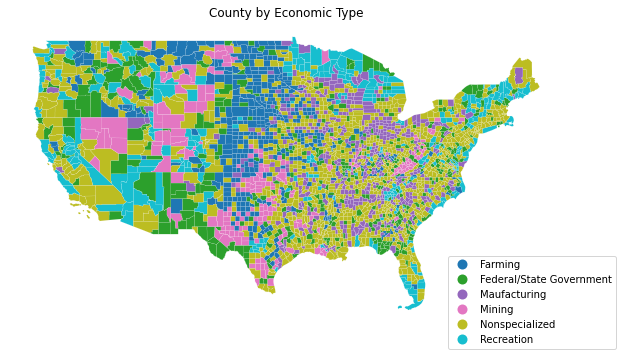

In [31]:
# plot
graph = 'Economic_Type_Label'
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,
         column=graph,
         edgecolor='white',
         linewidth=0.1,
         legend=True,
         legend_kwds={'loc': 'lower right',
                      'bbox_to_anchor' : (1.1, -.1)})

plt.title(label='County by Economic Type')
ax.set_axis_off()
fig.savefig('output/econtype.png', dpi=600, bbox_inches='tight')

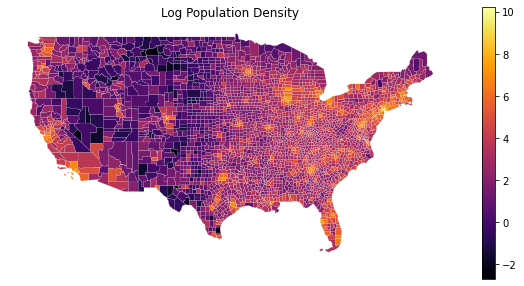

In [33]:
# plot log pop dens)
gdf['log_pop'] = np.log(gdf['pop'])
gdf['log_pop_dens'] = np.log(gdf['pop_dens'])

graph = 'log_pop_dens'
fig, ax = plt.subplots(figsize=(10, 10))
g = gdf.plot(ax=ax,
             column=graph,
             cmap='inferno',
             edgecolor='white',
             linewidth=0.1,
             legend=True,
             legend_kwds={'shrink': 0.5})

plt.title(label='Log Population Density')
ax.set_axis_off()
fig.savefig('output/logpopdens.png', dpi=600, bbox_inches='tight')

In [63]:
var

['married',
 'cohab',
 'cohab_children',
 'avg_hhsz',
 'pct_unmarpartner',
 'pct_nonrelative',
 'pct_educ',
 'pct_fb',
 'unempl',
 'avg_com',
 'pct_ag',
 'pct_manu',
 'med_inc',
 'inc_pc',
 'pct_pov',
 'pct_rent',
 'pct_no_veh',
 'med_homeval',
 'med_rent',
 'pop',
 'sex_ratio',
 'pct_20_24',
 'pct_25_34',
 'pct_un18',
 'pct_ov65',
 'pct_black',
 'pct_asian',
 'pct_hisp',
 'gini',
 'pct_20_34',
 'pop_dens',
 'TOTRATE']

In [ ]:
outcomes = ['marriage', 'cohab']
econ = ['med_homeval', 'med_rent', 'gini', 'inc_pc', 'pct_pov']
demo = ['pct_20_34', 'pct_fb', 'pct_black', 'pct_hisp']
social = ['pct_educ', 'pct_manu', 'pct_ag', 'unempl']
relig = ['TOTRATE', 'EVANRATE', 'MPRTRATE', 'CATHRATE',
         'CTHRATE', 'SBCRATE', 'UMCRATE', 'LDSRATE']

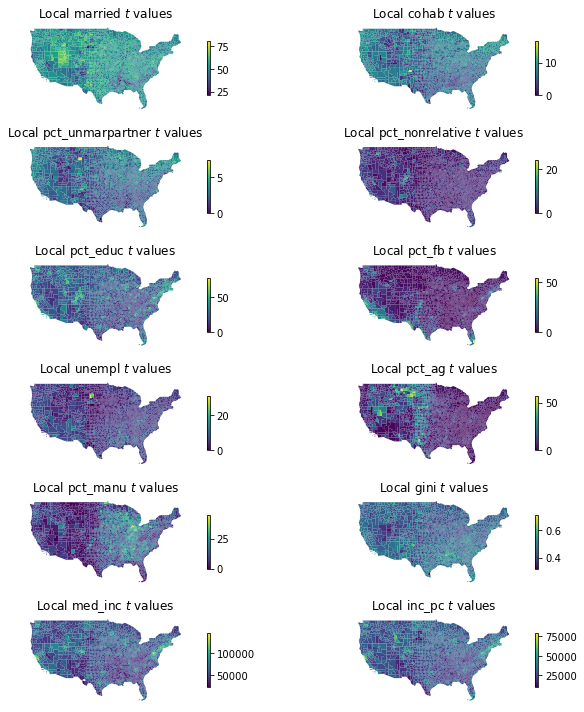

In [41]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 10))
for col, ax in zip(subvars, axes.flat):
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('{col}')
    #gdf = tvals.dropna(subset=[col], axis='rows')
    ax = gdf.plot(ax=ax,
                  column=col,
                  cmap='viridis',
                  legend=True,
                  legend_kwds={'shrink': 0.6})
fig.tight_layout()

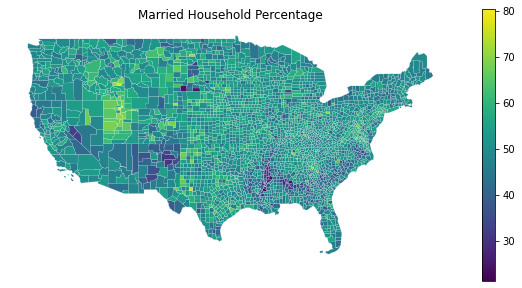

In [37]:
# plot marriage rates
fig, ax = plt.subplots(figsize=(10, 10))
g = gdf.plot(ax=ax,
             column='married',
             cmap='viridis',
             edgecolor='white',
             linewidth=0.1,
             legend=True,
             legend_kwds={'shrink': 0.5})

plt.title(label='Married Household Percentage')
ax.set_axis_off()

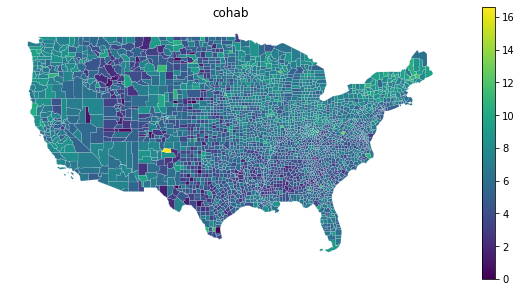

In [38]:
# plot cohabitation rate
graph = 'cohab'
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,
         column=graph,
         #scheme='NaturalBreaks',
         cmap='viridis',
         edgecolor='white',
         linewidth=0.1,
         legend=True,
         legend_kwds={'shrink': 0.5})

plt.title(label=graph)
ax.set_axis_off()

In [ ]:
# investigate the clear outlier
gdf[gdf['cohab'] > 13].sort_values(by='cohab', ascending=False)

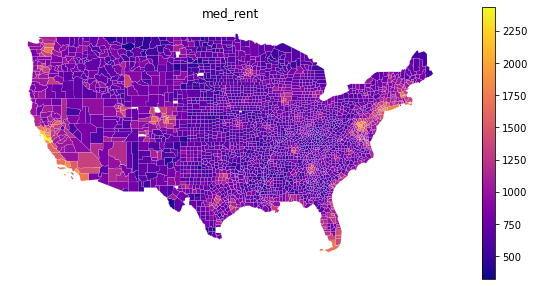

In [61]:
# plot unmarried partner rate
graph = 'med_rent'
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,
         column=graph,
         #scheme='NaturalBreaks',
         cmap='plasma',
         edgecolor='white',
         linewidth=0.1,
         legend=True,
         legend_kwds={'shrink': 0.5})

plt.title(label=graph)
ax.set_axis_off()

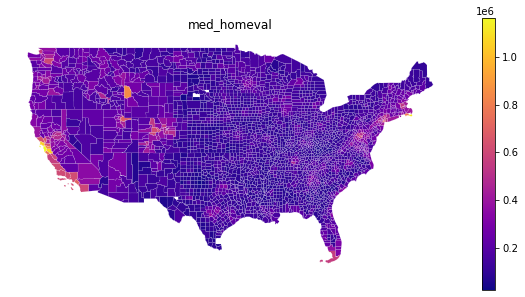

In [60]:
# plot unmarried partner rate
graph = 'med_homeval'
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,
         column=graph,
         #scheme='NaturalBreaks',
         cmap='plasma',
         edgecolor='white',
         linewidth=0.1,
         legend=True,
         legend_kwds={'shrink': 0.5})

plt.title(label=graph)
ax.set_axis_off()

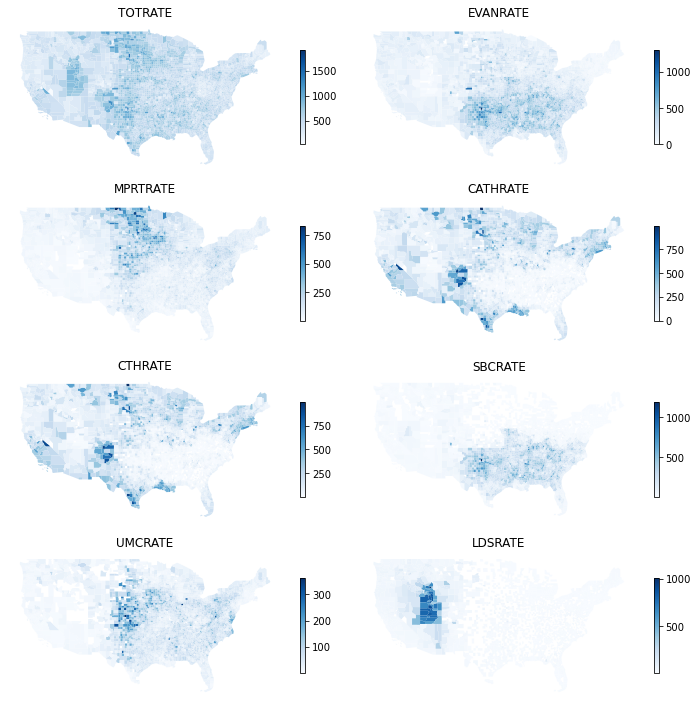

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for religion, ax in zip(relig, axes.flat):
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(religion)
    ax = gdf.plot(ax=ax,
                  column=religion,
                  cmap='Blues',
                  legend=True,
                  legend_kwds={'shrink': 0.6})
fig.tight_layout()

## 3. Global regression

In [64]:
import statsmodels.api as sm

In [65]:
m = gdf[var].corr()
#m.round(2)

In [ ]:
# Bivariate regression

# filter full dataset to retain only these columns and only rows without nulls in these columns
data = gdf[['cohab', 'pct_20_34']].dropna()

# create design matrix and response vector
X = data['pct_20_34']
y = data['cohab']

# estimate a simple linear regression model with OLS, using statsmodels
model = sm.OLS(y, sm.add_constant(X),)# cov_type='HC3_se')
result = model.fit()
print(result.summary())

In [ ]:
gdf.columns

In [ ]:
# Multivariate regression
response = 'cohab'
predictors = ['pct_20_34', 'pct_educ', 'pct_pov', 'unempl', 'pct_manu', 
              'pct_black', 'pct_hisp', 'sex_ratio',
              'gini', 'log_pop_dens', 'Recreation_2015_Update', 'TOTRATE']

# filter full dataset to retain only these columns and only rows without nulls in these columns
data = gdf[[response] + predictors].dropna()

# create design matrix and response vector
X = data[predictors]
y = data[response]

# estimate a simple linear regression model with OLS, using statsmodels
model = sm.OLS(y, sm.add_constant(X), cov_type='HC3')
result = model.fit()
print(result.summary())

In [ ]:
# Multivariate regression
response = 'cohab'
predictors = alls

# filter full dataset to retain only these columns and only rows without nulls in these columns
data = gdf[[response] + predictors].dropna()

# create design matrix and response vector
X = data[predictors]
y = data[response]

# estimate a simple linear regression model with OLS, using statsmodels
model = sm.OLS(y, sm.add_constant(X), cov_type='HC3_se')
result = model.fit()
print(result.summary())

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#gdf = gdf.set_index('GEOID')

In [ ]:
labels[:10]

## Spatial weights matrix

In [66]:
labels = gdf.index.tolist()
# calculate queen spatial weights
w_queen = ps.lib.weights.Queen.from_dataframe(gdf, ids=labels, id_order=labels)

In [67]:
# convert cardinalities to series and describe data
pd.Series(w_queen.cardinalities).describe()

count    3108.000000
mean        5.938224
std         1.314197
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
dtype: float64

In [68]:
# check for any isolated counties
w_queen.islands

[]

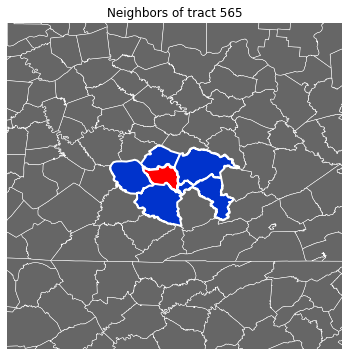

In [70]:
# visually verify Queen contiguity weights matrix
random_c = random.choice(labels)

fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(ax=ax, facecolor='#666666', edgecolor='w', linewidth=0.5)

# plot some tract of interest in red
county = gdf.loc[[random_c]]
county.plot(ax=ax, facecolor='#ff0000', edgecolor='w', linewidth=2)

# plot the neighbors in blue
neighbors = gdf.loc[w_queen[random_c]]
neighbors.plot(ax=ax, facecolor='#0033cc', edgecolor='w', linewidth=2)

# zoom to area of interest
xmin, ymin, xmax, ymax = neighbors.unary_union.bounds
ax.axis('equal')
ax.set_xlim(xmin-1, xmax+1)  # +/- 100 meters
ax.set_ylim(ymin, ymax)

ax.set_title('Neighbors of tract {}'.format(random_c))
_ = ax.axis('off')

In [71]:
# check the current transformation of the weights matrix (O = original)
w_queen.get_transform()

'O'

In [73]:
# transform the queen weights
w_queen.set_transform('R')
w_queen[random_c]

{561: 0.2, 597: 0.2, 566: 0.2, 552: 0.2, 606: 0.2}

In [74]:
# recompute spatial weights for just these observations then row-standardize
w_queen = ps.lib.weights.Queen.from_dataframe(gdf[['cohab', 'geometry']])
w_queen.set_transform('R')

In [125]:
# pick a variable to investigate (and drop null rows)
col = 'pct_unmarpartner'
tracts_not_null = gdf[[col, 'geometry']].dropna()
y = tracts_not_null[col]

In [126]:
# compute spatial lag
y_lag = ps.lib.weights.lag_spatial(w_queen, y)

In [127]:
# is a tract's med income similar to those of its neighbors?
col_lag = f'{col}_lag'
data_lag = pd.DataFrame(data={col:y, col_lag:y_lag}).astype(float)
data_lag

,pct_unmarpartner,pct_unmarpartner_lag
0,1.2,2.400000
1,2.7,2.287500
2,1.2,1.916667
3,2.9,1.133333
4,3.6,2.828571
...,...,...
3103,2.4,2.500000
3104,2.9,2.850000
3105,2.5,2.875000
3106,2.3,2.800000


In [128]:
# calculate the statistic
mi = ps.explore.esda.Moran(data_lag[col], w_queen)

In [129]:
# show the I value
mi.I

0.38642645242447354

In [130]:
# statistical inference: show the p value
mi.p_sim

0.001

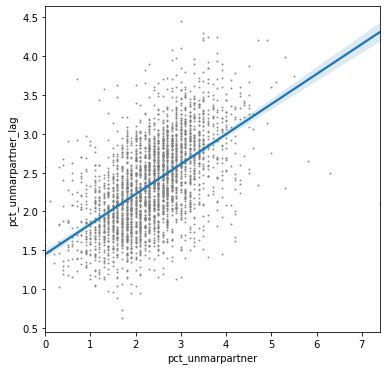

In [131]:
# Moran scatterplot
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(x=col, y=col_lag, data=data_lag, scatter_kws={'s':1, 'color':'gray'})
plt.show()

In [132]:
# Standardize outcome of interest
y_std = (y - y.mean()) / y.std()
y_std.head()

0   -1.431279
1    0.426666
2   -1.431279
3    0.674392
4    1.541432
Name: pct_unmarpartner, dtype: float64

In [133]:
# Compute spatial lag of standardized values and save as series with same index
y_std_lag = pd.Series(ps.lib.weights.lag_spatial(w_queen, y_std),
                      index=y_std.index,
                      name=col_lag)
y_std_lag.head()

0    0.055077
1   -0.084269
2   -0.543594
3   -1.513854
4    0.585918
Name: pct_unmarpartner_lag, dtype: float64

In [134]:
# estimate a simple linear regression model
m, b, r, p, se = stats.linregress(x=y_std, y=y_std_lag)
print('m={:.4f}, b={:.4f}, r^2={:.4f}, p={:.4f}'.format(m, b, r ** 2, p))

m=0.3864, b=0.0046, r^2=0.3111, p=0.0000


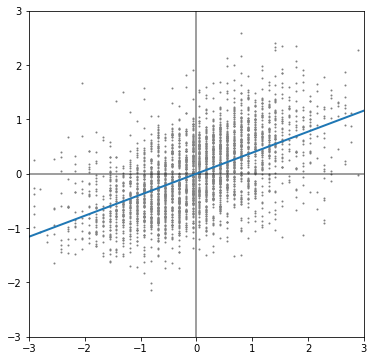

In [135]:
# standardized moran's plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=y_std, y=y_std_lag, s=1, color='gray')

# draw quadrants and ignore outliers beyond 3 std devs (99.7% of distribution)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# draw a line with moran's I as the slope
Xs = pd.Series([-3, 3])
Ys = Xs * mi.I
line = ax.plot(Xs, Ys, lw=2)

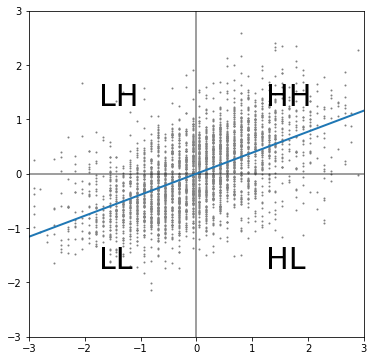

In [136]:
# standardized moran's plot again, from above, but labeled this time
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=y_std, y=y_std_lag, s=1, color='gray')

# draw quadrants and ignore outliers beyond 3 std devs
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# label the quadrants
ax.text(1.25, 1.25, 'HH', fontsize=30)
ax.text(1.25, -1.75, 'HL', fontsize=30)
ax.text(-1.75, 1.25, 'LH', fontsize=30)
ax.text(-1.75, -1.75, 'LL', fontsize=30)

# draw a line with moran's I as the slope
Xs = pd.Series([-3, 3])
Ys = Xs * mi.I
line = ax.plot(Xs, Ys, lw=2)

In [137]:
# calculate LISA values using the queen spatial weights
lisa = ps.explore.esda.Moran_Local(data_lag[col], w_queen)

In [138]:
# set the statistical significance threshold (alpha)
alpha = 0.05

In [139]:
# identify whether each observation is significant or not
# p-value interpretation same as earlier with moran's I
data_lag['significant'] = lisa.p_sim < alpha
data_lag['significant'].value_counts()

False    2061
True     1047
Name: significant, dtype: int64

In [140]:
# identify the quadrant each observation belongs to
data_lag['quadrant'] = lisa.q
data_lag['quadrant'] = data_lag['quadrant'].replace({1:'HH', 2:'LH', 3:'LL', 4:'HL'})
data_lag['quadrant'].sort_values().value_counts()

LL    1143
HH    1086
HL     465
LH     414
Name: quadrant, dtype: int64

In [141]:
# what have we got in the end?
data_lag

,pct_unmarpartner,pct_unmarpartner_lag,significant,quadrant
0,1.2,2.400000,False,LH
1,2.7,2.287500,False,HL
2,1.2,1.916667,False,LL
3,2.9,1.133333,True,HL
4,3.6,2.828571,False,HH
...,...,...,...,...
3103,2.4,2.500000,False,HH
3104,2.9,2.850000,False,HH
3105,2.5,2.875000,False,HH
3106,2.3,2.800000,False,LH


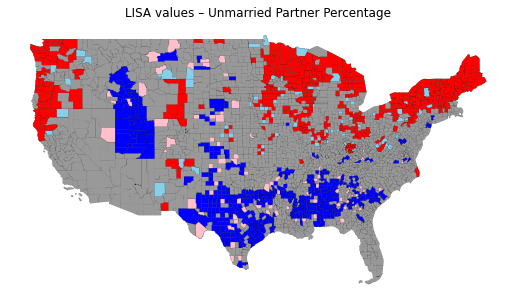

In [143]:
fig, ax = plt.subplots(figsize=(9, 9))

# merge original tracts and LISA quadrants data together, plot tracts basemap
gdf_lisa = gdf.merge(data_lag, how='left', left_index=True, right_index=True)
gdf_lisa.plot(ax=ax, facecolor='#999999', edgecolor='k', linewidth=0.1)

# plot each quandrant's tracts (if significant LISA) in a different color
quadrant_colors = {'HH':'r', 'LL':'b', 'LH':'skyblue', 'HL':'pink'}
for q, c in quadrant_colors.items():
    mask = gdf_lisa['significant'] & (gdf_lisa['quadrant']==q)
    rows = gdf_lisa.loc[mask]
    rows.plot(ax=ax, color=c, edgecolor='k', linewidth=0.1)

    
plt.title(label='LISA values – Unmarried Partner Percentage')
ax.axis('off')
fig.savefig('output/LISA_unmarriedpartner.png', dpi=600, bbox_inches='tight')

  - Gray tracts have statistically-insignificant LISA value (no local spatial autocorrelation)
  - In red we see clusters of tracts with high values surrounded by other high values
  - In blue we see clusters of tracts with low values surrounded by other low values
  - In pink, we see the first type of spatial outliers: tracts with high values but surrounded by low values
  - In light blue we see the other type of spatial outlier: tracts with low values surrounded by other tracts with high values

In [ ]:
gdf.to_csv('data.csv')

In [192]:
gdf.to_file('counties_acs',driver ='ESRI Shapefile')